## Env

In [72]:
import pandas
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import os
from tensorflow.keras.initializers import Constant

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 로더

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Tokenizer

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어 제거
5. 사전(word_to_index) 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [10]:
tokenizer = Mecab() # 형태소 분석을 위한 Mecab
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any') # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    test_data = test_data.dropna(how = 'any') # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    # 단어 사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # 빈도 계산
    counter = counter.most_common(10000-4) # 특수 토큰을 위해 -4 (패딩, 시작, 종료, 미등록)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [11]:
# word_to_index 사전을 역으로 변환하여, 단어에 대응하는 인덱스를 다시 단어로 변환
index_to_word = {index:word for word, index in word_to_index.items()} 

In [18]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 
word_to_index["<UNUSED>"] = 3

In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

In [21]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [23]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성

In [24]:
vocab_size = 10000 # 어휘 사전 크기
word_vector_dim = 16 # 워드 벡터 차원 수

In [27]:
# 1. LSTM
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model1.add(tf.keras.layers.LSTM(16))
model1.add(tf.keras.layers.Dense(16, activation = 'relu'))
model1.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # 긍정 부정을 나타내야하기에

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 2. BiLSTM
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))  
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))) 
model2.add(tf.keras.layers.Dense(16, activation='relu')) 
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 164,769
Trainable params: 164,769
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 3. Stacked LSTM
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model3.add(tf.keras.layers.LSTM(64, return_sequences = True)) # 출력 시퀀스로 반환
model3.add(tf.keras.layers.LSTM(32)) # 출력 시퀀슬 반환 X
model3.add(tf.keras.layers.Dense(16, activation = 'relu'))
model3.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          20736     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 193,697
Trainable params: 193,697
Non-trainable params: 0
_________________________________________________________________


In [32]:
x_val = X_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지
partial_x_train = X_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


In [52]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 30  

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
91/91 [==============================] - 3s 15ms/step - loss: 0.0353 - accuracy: 0.9878 - val_loss: 1.7093 - val_accuracy: 0.7824
Epoch 2/30
91/91 [==============================] - 1s 10ms/step - loss: 0.0394 - accuracy: 0.9864 - val_loss: 1.7372 - val_accuracy: 0.7866
Epoch 3/30
91/91 [==============================] - 1s 10ms/step - loss: 0.0304 - accuracy: 0.9893 - val_loss: 1.8682 - val_accuracy: 0.7843
Epoch 4/30
91/91 [==============================] - 1s 10ms/step - loss: 0.0345 - accuracy: 0.9881 - val_loss: 1.8568 - val_accuracy: 0.7834
Epoch 5/30
91/91 [==============================] - 1s 10ms/step - loss: 0.0348 - accuracy: 0.9878 - val_loss: 1.7761 - val_accuracy: 0.7845
Epoch 6/30
91/91 [==============================] - 1s 10ms/step - loss: 0.0412 - accuracy: 0.9861 - val_loss: 1.7148 - val_accuracy: 0.7845
Epoch 7/30
91/91 [==============================] - 1s 10ms/step - loss: 0.0353 - accuracy: 0.9874 - val_loss: 1.7382 - val_accuracy: 0.7836
Epoch 8/30
91

In [53]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 30  

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
91/91 [==============================] - 5s 21ms/step - loss: 0.0381 - accuracy: 0.9872 - val_loss: 1.8143 - val_accuracy: 0.7816
Epoch 2/30
91/91 [==============================] - 1s 13ms/step - loss: 0.0301 - accuracy: 0.9906 - val_loss: 1.8166 - val_accuracy: 0.7832
Epoch 3/30
91/91 [==============================] - 1s 14ms/step - loss: 0.0281 - accuracy: 0.9913 - val_loss: 1.8637 - val_accuracy: 0.7792
Epoch 4/30
91/91 [==============================] - 1s 13ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 2.0076 - val_accuracy: 0.7813
Epoch 5/30
91/91 [==============================] - 1s 14ms/step - loss: 0.0350 - accuracy: 0.9885 - val_loss: 1.8130 - val_accuracy: 0.7837
Epoch 6/30
91/91 [==============================] - 1s 14ms/step - loss: 0.0331 - accuracy: 0.9892 - val_loss: 1.8662 - val_accuracy: 0.7828
Epoch 7/30
91/91 [==============================] - 1s 13ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 1.8355 - val_accuracy: 0.7799
Epoch 8/30
91

In [54]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 30  

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
91/91 [==============================] - 5s 23ms/step - loss: 0.0151 - accuracy: 0.9937 - val_loss: 2.0121 - val_accuracy: 0.7892
Epoch 2/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0118 - accuracy: 0.9950 - val_loss: 2.0257 - val_accuracy: 0.7907
Epoch 3/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0151 - accuracy: 0.9939 - val_loss: 2.0084 - val_accuracy: 0.7883
Epoch 4/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 2.0242 - val_accuracy: 0.7909
Epoch 5/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0143 - accuracy: 0.9943 - val_loss: 1.9811 - val_accuracy: 0.7888
Epoch 6/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0114 - accuracy: 0.9952 - val_loss: 2.0605 - val_accuracy: 0.7886
Epoch 7/30
91/91 [==============================] - 1s 15ms/step - loss: 0.0095 - accuracy: 0.9959 - val_loss: 2.1649 - val_accuracy: 0.7906
Epoch 8/30
91

In [55]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 2.5302 - accuracy: 0.7773
[2.5301895141601562, 0.7772646546363831]


In [56]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 2.5973 - accuracy: 0.7750
[2.5973281860351562, 0.7750065922737122]


In [57]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 4s - loss: 2.7057 - accuracy: 0.7864
[2.705745220184326, 0.7864190340042114]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


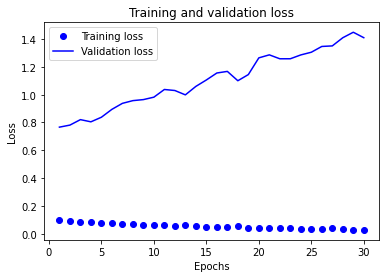

In [64]:
history_dict1 = history.history
print(history_dict1.keys()) 

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

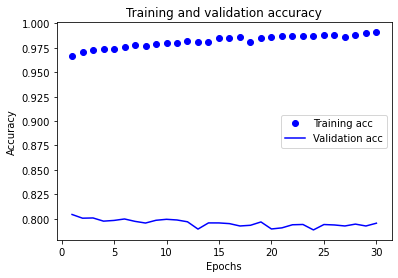

In [65]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


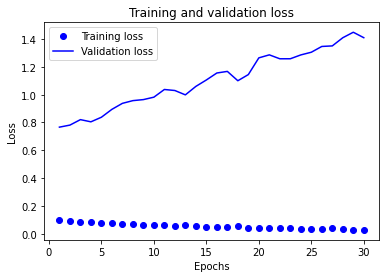

In [66]:
history_dict2 = history.history
print(history_dict2.keys()) 

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

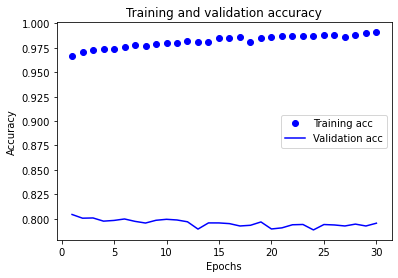

In [67]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


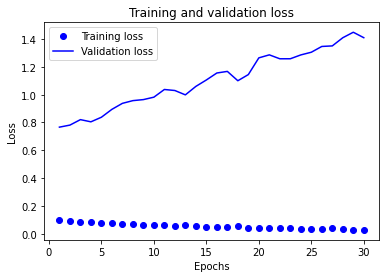

In [68]:
history_dict3 = history.history
print(history_dict3.keys()) 

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

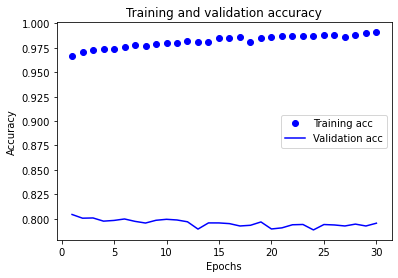

In [69]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [89]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [97]:
from gensim.models import Word2Vec
# Word2Vec 모델 파일 경로
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'

# Word2Vec 모델 로드
model = Word2Vec.load(word2vec_file_path)

In [106]:
# from gensim.models.keyedvectors import Word2VecKeyedVectors

# word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
# vector = word_vectors['computer']
# vector

UnpicklingError: invalid load key, '3'.

In [99]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [100]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

In [113]:
# model3.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# epochs = 50  

# history4 = model3.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=epochs,
#                     batch_size=1024,
#                     validation_data=(x_val, y_val),
#                     verbose=1)

Epoch 1/50
46/46 [==============================] - 4s 38ms/step - loss: 0.0032 - accuracy: 0.9982 - val_loss: 2.5702 - val_accuracy: 0.7874
Epoch 2/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0028 - accuracy: 0.9984 - val_loss: 2.5755 - val_accuracy: 0.7905
Epoch 3/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0031 - accuracy: 0.9985 - val_loss: 2.5306 - val_accuracy: 0.7911
Epoch 4/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0041 - accuracy: 0.9979 - val_loss: 2.5502 - val_accuracy: 0.7829
Epoch 5/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0040 - accuracy: 0.9979 - val_loss: 2.3437 - val_accuracy: 0.7905
Epoch 6/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0033 - accuracy: 0.9982 - val_loss: 2.4155 - val_accuracy: 0.7930
Epoch 7/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0028 - accuracy: 0.9982 - val_loss: 2.4745 - val_accuracy: 0.7913
Epoch 8/50
46

In [115]:
# 모델 정의
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)) 
model4.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)) 
model4.add(tf.keras.layers.Dense(32, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.5)) # Dropout 추가
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# 모델 요약
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 128)         219648    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 3,271,169
Trainable params: 3,271,169
Non-trainable params: 0
____________________________________________

In [119]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 25  

history4 = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/25
91/91 [==============================] - 46s 446ms/step - loss: 0.0894 - accuracy: 0.9651 - val_loss: 0.8517 - val_accuracy: 0.8291
Epoch 2/25
91/91 [==============================] - 40s 445ms/step - loss: 0.0709 - accuracy: 0.9709 - val_loss: 1.0120 - val_accuracy: 0.8201
Epoch 3/25
91/91 [==============================] - 40s 444ms/step - loss: 0.0664 - accuracy: 0.9733 - val_loss: 0.9641 - val_accuracy: 0.8175
Epoch 4/25
91/91 [==============================] - 40s 441ms/step - loss: 0.0613 - accuracy: 0.9755 - val_loss: 1.1007 - val_accuracy: 0.8218
Epoch 5/25
91/91 [==============================] - 41s 446ms/step - loss: 0.0549 - accuracy: 0.9785 - val_loss: 1.1826 - val_accuracy: 0.8213
Epoch 6/25
91/91 [==============================] - 40s 437ms/step - loss: 0.0530 - accuracy: 0.9787 - val_loss: 1.2188 - val_accuracy: 0.8210
Epoch 7/25
91/91 [==============================] - 40s 439ms/step - loss: 0.0500 - accuracy: 0.9806 - val_loss: 1.2814 - val_accuracy: 0.8232

In [120]:
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 36s - loss: 1.8006 - accuracy: 0.8146
[1.8006069660186768, 0.8145737051963806]


### 회고
- 잘 진행했는 지 모르겠다.
- 파이토치만 쓰다가 텐서플로우와 케라스를 사용하니 더 어려운 것 같다.
- 모델을 다양하게 써봐서 좋은 경험이었다.
- 예상은 LSTM보다 BiLSTM, Stacked LSTM이 훨씬 뛰어난 성능을 보일 것 같았는데 test에 대한 acc값은 큰 차이가 나지 않았다.
- 시간이 조금 더 있었더라면 성능을 높일 수 있을 것 같은데 아쉽다. ㅜ
- 자연어 어렵다